# Phishing URL Neural Network Experiments

This notebook explores various neural network architectures using the Kaggle phishing URL dataset.

In increasing order of complexity, we will experiment with:

1. Simple Feedforward Neural Networks (MLP)
2. Convolutional Neural Networks (CNN)
3. Recurrent Neural Networks (RNN)
4. Hybrid Models

## Setup and Imports

In [13]:
use_drive = False

# uncomment lines below if running on colab
from google.colab import drive
import os
drive.mount('/content/drive')
use_drive = True
drive_root = '/content/drive/MyDrive/fraud-grp-proj/'
print(os.path.exists(drive_root)) # check path exists

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [14]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Using device: cuda


In [15]:
# Load train and test datasets
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

train_w_features_df = pd.read_csv('dataset/df_train_feature_engineered.csv')
test_w_features_df = pd.read_csv('dataset/df_test_feature_engineered.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

print(f"Train with features shape: {train_w_features_df.shape}")
print(f"Test with features shape: {test_w_features_df.shape}")

Train shape: (9143, 2)
Test shape: (2286, 2)
Train with features shape: (9143, 78)
Test with features shape: (2286, 78)


In [16]:
train_w_features_df.columns

Index(['url', 'target', 'is_http', 'has_subdomain', 'has_tld', 'num_subdomain',
       'is_domain_ip', 'num_hyphens_domain', 'is_punycode', 'has_path',
       'path_depth', 'has_filename', 'has_file_extension', 'has_query',
       'length_url', 'length_hostname', 'length_tld', 'length_sld',
       'length_subdomains', 'length_path', 'length_query', 'num_dots',
       'num_hyphens', 'num_at', 'num_question_marks', 'num_and', 'num_equal',
       'num_percent', 'tld_in_path', 'tld_in_subdomain',
       'subdomain_longer_sld', 'ratio_digits_url', 'ratio_digits_hostname',
       'ratio_letter_url', 'ratio_path_url', 'ratio_hostname_url',
       'length_words_url', 'avg_word_hostname', 'avg_word_path',
       'num_unique_chars_hostname', 'has_shortened_hostname',
       'entropy_hostname', 'has_www_subdomain', 'has_com_tld',
       'is_http_and_many_subdomains', 'ip_and_short_tld',
       'http_and_missing_domain_info', 'subdomain_depth_x_http', 'ip_x_http',
       'domain_complexity_score',

Following the EDA, we use the same feature set as log regression since MLP models require normalized and scaled inputs.

In [17]:
# Drop original versions of log transformed features
train_w_features_df.drop(columns=['length_url', 'length_path',  'ratio_hostname_url', 'length_words_url', 'avg_word_hostname', 'num_unique_chars_hostname'], inplace=True)

# Drop original versions of squared transformed features
train_w_features_df.drop(columns=['ratio_letter_url', 'entropy_hostname'], inplace=True)

# Drop original versions of is_zero transformed features
train_w_features_df.drop(columns=['num_hyphens_domain', 'length_subdomains', 'num_hyphens',  'num_at', 'num_question_marks', 'num_and', 'num_equal', 'num_percent', 'ratio_digits_url', 'ratio_digits_hostname', 'avg_word_path', 'length_query'], inplace=True)

# Drop original versions of bucketed transformed features
train_w_features_df.drop(columns=['num_subdomain', 'length_tld', 'path_depth'], inplace=True)

# Check final columns
train_w_features_df.columns

Index(['url', 'target', 'is_http', 'has_subdomain', 'has_tld', 'is_domain_ip',
       'is_punycode', 'has_path', 'has_filename', 'has_file_extension',
       'has_query', 'length_hostname', 'length_sld', 'num_dots', 'tld_in_path',
       'tld_in_subdomain', 'subdomain_longer_sld', 'ratio_path_url',
       'has_shortened_hostname', 'has_www_subdomain', 'has_com_tld',
       'is_http_and_many_subdomains', 'ip_and_short_tld',
       'http_and_missing_domain_info', 'subdomain_depth_x_http', 'ip_x_http',
       'domain_complexity_score', 'suspicion_score', 'contains_brand_misspell',
       'is_homoglyph_attack', 'homoglyph_type', 'risk_score',
       'is_zero_num_hyphens_domain', 'is_zero_length_subdomains',
       'is_zero_num_hyphens', 'is_zero_num_at', 'is_zero_num_question_marks',
       'is_zero_num_and', 'is_zero_num_equal', 'is_zero_num_percent',
       'is_zero_ratio_digits_url', 'is_zero_ratio_digits_hostname',
       'is_zero_avg_word_path', 'is_zero_length_query',
       'num_sub

## Training Models

Now lets move on to training the models. We use the `ModelSaver` utility to help us standardize the storing of metrics and models for evaluation later on.

In [18]:
# Configuration
SAVE_MODELS = True  # Switch to turn on/off model saving
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
MAX_URL_LEN = 200  # Truncate/pad URLs to this length
EMBEDDING_DIM = 64
DROPOUT = 0.3

# Early stopping config: patience = number of epochs with no improvement in validation loss
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_MIN_DELTA = 1e-4

# Import ModelSaver
import sys
import os
sys.path.append(os.path.abspath('.'))
from save_model import ModelSaver

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [19]:
# --- Data Preprocessing for Neural Networks ---

# 1. Character Tokenizer for URLs
class CharTokenizer:
    def __init__(self):
        self.char2idx = {}
        self.idx2char = {}
        self.vocab_size = 0

    def fit(self, texts):
        unique_chars = set()
        for text in texts:
            unique_chars.update(str(text))

        self.char2idx = {char: idx + 2 for idx, char in enumerate(sorted(unique_chars))}
        self.char2idx['<PAD>'] = 0
        self.char2idx['<UNK>'] = 1
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}
        self.vocab_size = len(self.char2idx)

    def transform(self, texts, max_len):
        sequences = []
        for text in texts:
            text = str(text)
            seq = [self.char2idx.get(c, 1) for c in text]
            if len(seq) < max_len:
                seq = seq + [0] * (max_len - len(seq))
            else:
                seq = seq[:max_len]
            sequences.append(seq)
        return np.array(sequences)


tokenizer = CharTokenizer()
tokenizer.fit(train_df['url'])
print(f"Vocabulary size: {tokenizer.vocab_size}")

# 2. Prepare Numeric Features (includes explicit boolean handling)
# - Select numeric columns and boolean columns separately.
# - Convert boolean columns to 0/1 numeric values for scaling and model input.
numeric_cols = train_w_features_df.select_dtypes(include=[np.number]).columns.tolist()
# pandas has two boolean dtypes: 'bool' (built-in) and 'boolean' (pandas extension)
bool_cols = list(train_w_features_df.select_dtypes(include=['bool', 'boolean']).columns)

# Remove target from features if present
if 'target' in numeric_cols:
    numeric_cols.remove('target')
if 'target' in bool_cols:
    bool_cols.remove('target')

# Convert boolean columns to numeric (0/1) in both train and test DataFrames
for df in (train_w_features_df, test_w_features_df):
    for col in bool_cols:
        if col in df.columns:
            # Map True/False to 1/0; preserves NaNs when present
            df[col] = df[col].map({True: 1, False: 0})
            # Ensure dtype is numeric for scaler
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure boolean columns are included in numeric_cols
for c in bool_cols:
    if c not in numeric_cols:
        numeric_cols.append(c)

# Coerce all numeric columns to numeric dtype and align train/test
for df in (train_w_features_df, test_w_features_df):
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for NaNs introduced by coercion and impute using train medians where needed
nan_cols = [c for c in numeric_cols if c in train_w_features_df.columns and train_w_features_df[c].isnull().any()]
if nan_cols:
    print("Warning: NaNs found in numeric columns after coercion. Imputing with train median for:", nan_cols)
    for col in nan_cols:
        median_val = train_w_features_df[col].median()
        train_w_features_df[col].fillna(median_val, inplace=True)
        # Fill test with same median to avoid data leakage
        if col in test_w_features_df.columns:
            test_w_features_df[col].fillna(median_val, inplace=True)

# Final arrays for numeric features
X_numeric_train = train_w_features_df[numeric_cols].astype(float).values
X_numeric_test = test_w_features_df[numeric_cols].astype(float).values

# 3. Scale numeric features
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

# 4. Prepare Text Features
X_text_train = tokenizer.transform(train_df['url'], MAX_URL_LEN)
X_text_test = tokenizer.transform(test_df['url'], MAX_URL_LEN)

# 5. Prepare Targets
y_train = train_df['target'].values
if 'target' in test_df.columns:
    y_test = test_df['target'].values
else:
    y_test = np.zeros(len(test_df))

# 6. Create PyTorch Datasets
class PhishingDataset(Dataset):
    def __init__(self, X_numeric, X_text, y, X_images=None):
        self.X_numeric = torch.FloatTensor(X_numeric)
        self.X_text = torch.LongTensor(X_text)
        self.y = torch.FloatTensor(y)
        self.X_images = torch.FloatTensor(X_images) if X_images is not None else None

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.X_images is not None:
            return self.X_numeric[idx], self.X_text[idx], self.X_images[idx], self.y[idx]
        return self.X_numeric[idx], self.X_text[idx], self.y[idx]


full_train_dataset = PhishingDataset(X_numeric_train_scaled, X_text_train, y_train)
test_dataset = PhishingDataset(X_numeric_test_scaled, X_text_test, y_test)


test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data preparation complete.")

Vocabulary size: 101
Data preparation complete.


In [20]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for batch in loader:
        x_img = None
        if len(batch) == 3:
            x_num, x_txt, y = batch
        else:
            x_num, x_txt, x_img, y = batch
            x_img = x_img.to(device)

        x_num, x_txt, y = x_num.to(device), x_txt.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x_num, x_txt, x_img).squeeze()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_num.size(0)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(y.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in loader:
            x_img = None
            if len(batch) == 3:
                x_num, x_txt, y = batch
            else:
                x_num, x_txt, x_img, y = batch
                x_img = x_img.to(device)

            x_num, x_txt, y = x_num.to(device), x_txt.to(device), y.to(device)

            outputs = model(x_num, x_txt, x_img).squeeze()
            loss = criterion(outputs, y)

            running_loss += loss.item() * x_num.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Convert probabilities to binary predictions
    binary_preds = (all_preds > 0.5).astype(int)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(all_targets, binary_preds).ravel()

    metrics = {
        'loss': epoch_loss,
        'accuracy': accuracy_score(all_targets, binary_preds),
        'precision': precision_score(all_targets, binary_preds, zero_division=0),
        'recall': recall_score(all_targets, binary_preds, zero_division=0),
        'f1': f1_score(all_targets, binary_preds, zero_division=0),
        'roc_auc': roc_auc_score(all_targets, all_preds),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    }

    return metrics, all_preds


def run_experiment(model_class, model_name, model_params, experiment_name, save_model=True):
    print(f"\n=== Running Experiment: {experiment_name} ({model_name}) ===")
    print(f"Saving Model: {save_model}")

    saver = None
    if save_model:
        if use_drive:
            base_path = drive_root + "experiments"
        else:
            base_path = "experiments"
        saver = ModelSaver(base_path=base_path)
        saver.start_experiment(
            experiment_name=experiment_name,
            model_type=model_name,
            vectorizer="CharTokenizer/Visualizer",
            vectorizer_params={'vocab_size': tokenizer.vocab_size, 'max_len': MAX_URL_LEN},
            model_params=model_params,
            n_folds=5,
            save_format="pickle"
        )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_test_preds = []

    # Store per-fold loss curves
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_numeric_train_scaled, y_train), start=1):
        print(f"\n--- Fold {fold}/5 ---")

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        val_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        model = model_class(**model_params).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        best_val_loss = float('inf')
        best_val_auc = 0.0
        best_model_state = None

        # Per-epoch lists for this fold
        train_losses = []
        val_losses = []

        no_improve_count = 0

        for epoch in range(EPOCHS):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_metrics, _ = evaluate(model, val_loader, criterion, device)
            val_loss = val_metrics['loss']

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Provide periodic logging
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val AUC: {val_metrics['roc_auc']:.4f}")

            # Track best model based on validation loss
            if val_loss + EARLY_STOPPING_MIN_DELTA < best_val_loss:
                best_val_loss = val_loss
                best_val_auc = val_metrics['roc_auc']
                best_model_state = model.state_dict()
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Early stopping check
            if no_improve_count >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1} (no improvement in val loss for {EARLY_STOPPING_PATIENCE} epochs)")
                break

        # Save the per-fold losses
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        if best_model_state:
            model.load_state_dict(best_model_state)

        val_metrics, val_preds = evaluate(model, val_loader, criterion, device)
        print(f"Fold {fold} Best Val AUC: {val_metrics['roc_auc']:.4f}")

        test_metrics, test_preds = evaluate(model, test_loader, criterion, device)
        fold_test_preds.append(test_preds)

        if save_model and saver:
            saver.add_fold(
                fold_model=model,
                fold_metric={"fold": fold, **val_metrics, "train_size": len(train_idx), "val_size": len(val_idx)},
                test_predictions=test_preds,
                feature_names=["numeric_features"]
            )

    # Plot loss curves for all folds — ensure train/val share the same color per fold
    try:
        plt.figure(figsize=(10, 6))

        n_folds = len(fold_train_losses)
        # Choose a qualitative colormap with at least n_folds distinct colors
        cmap = plt.get_cmap('tab10' if n_folds <= 10 else 'tab20')

        for i, (tr_losses, v_losses) in enumerate(zip(fold_train_losses, fold_val_losses), start=1):
            color = cmap((i - 1) % cmap.N)

            epochs_range = range(1, len(tr_losses) + 1)
            plt.plot(epochs_range, tr_losses, label=f"Fold {i} Train", linestyle='-', color=color, linewidth=1.5)

            # val_losses may be shorter/longer than train if early stopping triggers
            epochs_val_range = range(1, len(v_losses) + 1)
            plt.plot(epochs_val_range, v_losses, label=f"Fold {i} Val", linestyle='--', color=color, linewidth=1.5)

        plt.title(f"Train & Val Loss per Fold — {experiment_name} ({model_name})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(ncol=2)
        plt.grid(True)

        # Save plot to experiment directory if saver exists
        if save_model and saver and hasattr(saver, '_exp_dir'):
            plot_path = os.path.join(saver._exp_dir, f"{experiment_name}_{model_name}_loss_curves.png")
            plt.savefig(plot_path, bbox_inches='tight')
            print(f"Saved loss curves to {plot_path}")

        plt.show()
    except Exception as ex:
        print("Could not produce loss plot:", ex)

    if save_model and saver:
        saver.finalize_experiment()
        print(f"Experiment saved to {saver._exp_dir}")

    return model, val_metrics, test_metrics

### 1. Baseline MLP (Numeric Features Only)

In [21]:
# Define Baseline MLP Architecture
class BaselineMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.3):
        super(BaselineMLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x_numeric, x_text=None, x_img=None):
        # Ignores x_text, x_img
        return torch.sigmoid(self.network(x_numeric))


=== Running Experiment: exp_3_mlp_baseline (BaselineMLP) ===
Saving Model: True
Experiment 'exp_3_mlp_baseline' initialized at: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_mlp_baseline
Mode: Incremental saving (5 folds)

--- Fold 1/5 ---
Epoch 1/20 - Train Loss: 0.3976 - Val Loss: 0.0718 - Val AUC: 0.9228
Epoch 5/20 - Train Loss: 0.2281 - Val Loss: 0.0523 - Val AUC: 0.9606
Epoch 10/20 - Train Loss: 0.2109 - Val Loss: 0.0507 - Val AUC: 0.9628
Epoch 15/20 - Train Loss: 0.1936 - Val Loss: 0.0491 - Val AUC: 0.9651
Early stopping triggered at epoch 19 (no improvement in val loss for 5 epochs)
Fold 1 Best Val AUC: 0.9666
  Fold 1/5 saved | ROC AUC: 0.9666

--- Fold 2/5 ---
Epoch 1/20 - Train Loss: 0.3810 - Val Loss: 0.0749 - Val AUC: 0.9113
Epoch 5/20 - Train Loss: 0.2238 - Val Loss: 0.0554 - Val AUC: 0.9539
Epoch 10/20 - Train Loss: 0.2042 - Val Loss: 0.0532 - Val AUC: 0.9573
Epoch 15/20 - Train Loss: 0.1879 - Val Loss: 0.0510 - Val AUC: 0.9609
Epoch 20/20 - Train Loss: 0.1809 

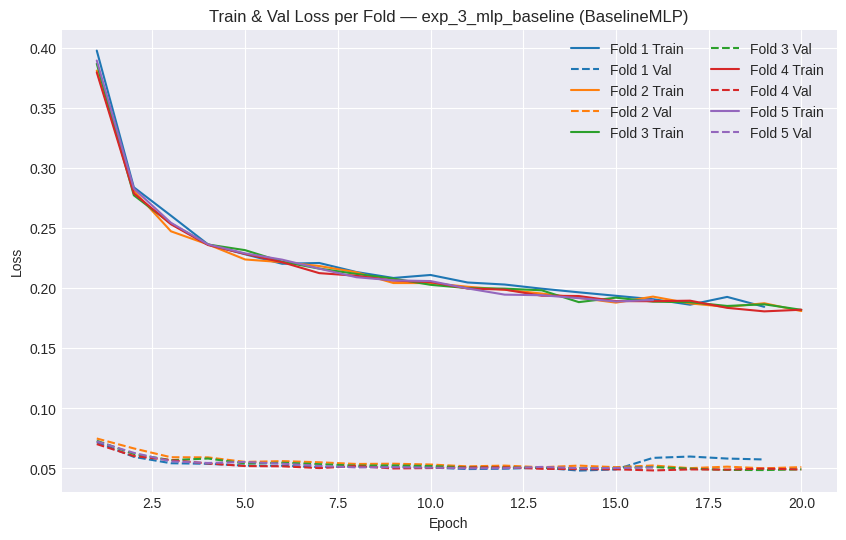


Finalizing experiment...
  Predictions saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_mlp_baseline/exp_3_mlp_baseline_prediction.csv

✓ Experiment 'exp_3_mlp_baseline' finalized!
  Location: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_mlp_baseline
  Folds completed: 5
  Best fold: 1 (ROC AUC: 0.9666)
  Average ROC AUC: 0.9636 ± 0.0017
Experiment saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_mlp_baseline


(BaselineMLP(
   (network): Sequential(
     (0): Linear(in_features=49, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, out_features=64, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.3, inplace=False)
     (6): Linear(in_features=64, out_features=32, bias=True)
     (7): ReLU()
     (8): Dropout(p=0.3, inplace=False)
     (9): Linear(in_features=32, out_features=1, bias=True)
   )
 ),
 {'loss': 0.050728092546420245,
  'accuracy': 0.9015317286652079,
  'precision': 0.9189497716894978,
  'recall': 0.8807439824945296,
  'f1': 0.8994413407821229,
  'roc_auc': np.float64(0.9619874885682957),
  'TP': np.int64(805),
  'FP': np.int64(71),
  'TN': np.int64(843),
  'FN': np.int64(109)},
 {'loss': 0.24951214758534235,
  'accuracy': 0.9041994750656168,
  'precision': 0.9223034734917733,
  'recall': 0.8827646544181977,
  'f1': 0.902101028162718,
  'roc_auc': np.float64(0.9628722590778516),
  'TP': np.int64(1009),
  'FP': n

In [22]:
# Run Baseline MLP Experiment
SAVE_MLP = True # Set to False to skip saving

mlp_params = {
    'input_dim': X_numeric_train_scaled.shape[1],
    'hidden_dims': [128, 64, 32],
    'dropout': DROPOUT
}

run_experiment(BaselineMLP, "BaselineMLP", mlp_params, "exp_3_mlp_baseline", save_model=SAVE_MLP)

### 2. CharCNN (Text Features Only)

In [23]:
# Define CharCNN Architecture
class CharCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, num_filters=128, filter_sizes=[3, 4, 5], dropout=0.3, max_len=200):
        super(CharCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, 1)

    def forward(self, x_numeric, x_text, x_img=None):
        # Ignores x_numeric, x_img
        # x_text shape: [batch_size, max_len]
        embedded = self.embedding(x_text) # [batch_size, max_len, emb_dim]

        # Permute for Conv1d: [batch_size, emb_dim, max_len]
        embedded = embedded.permute(0, 2, 1)

        # Apply Convs + ReLU + MaxPool
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate
        cat = torch.cat(pooled, dim=1)
        dropped = self.dropout(cat)

        return torch.sigmoid(self.fc(dropped))


=== Running Experiment: exp_3_charcnn (CharCNN) ===
Saving Model: True
Experiment 'exp_3_charcnn' initialized at: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_charcnn
Mode: Incremental saving (5 folds)

--- Fold 1/5 ---
Epoch 1/20 - Train Loss: 0.3385 - Val Loss: 0.0643 - Val AUC: 0.9407
Epoch 5/20 - Train Loss: 0.1632 - Val Loss: 0.0426 - Val AUC: 0.9737
Epoch 10/20 - Train Loss: 0.0954 - Val Loss: 0.0371 - Val AUC: 0.9795
Epoch 15/20 - Train Loss: 0.0518 - Val Loss: 0.0362 - Val AUC: 0.9819
Early stopping triggered at epoch 18 (no improvement in val loss for 5 epochs)
Fold 1 Best Val AUC: 0.9816
  Fold 1/5 saved | ROC AUC: 0.9816

--- Fold 2/5 ---
Epoch 1/20 - Train Loss: 0.3348 - Val Loss: 0.0657 - Val AUC: 0.9445
Epoch 5/20 - Train Loss: 0.1521 - Val Loss: 0.0501 - Val AUC: 0.9705
Epoch 10/20 - Train Loss: 0.0811 - Val Loss: 0.0413 - Val AUC: 0.9752
Early stopping triggered at epoch 14 (no improvement in val loss for 5 epochs)
Fold 2 Best Val AUC: 0.9756
  Fold 2/5 save

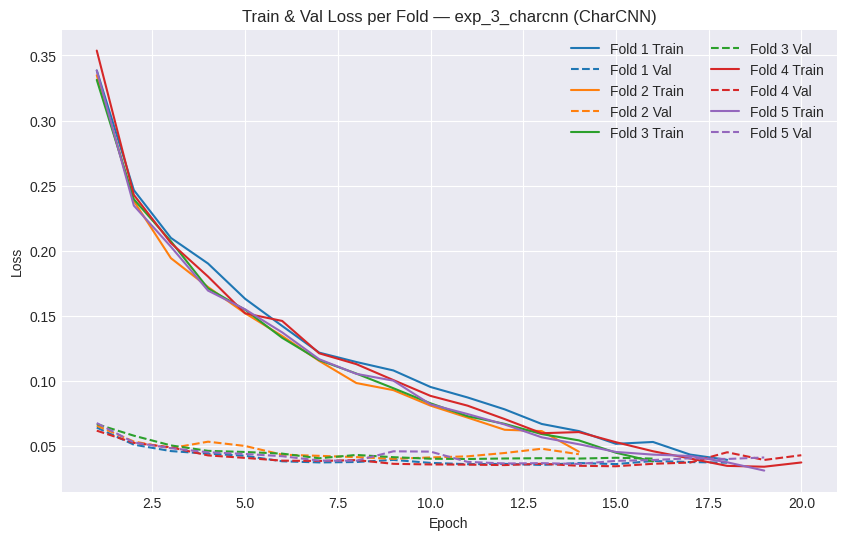


Finalizing experiment...
  Predictions saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_charcnn/exp_3_charcnn_prediction.csv

✓ Experiment 'exp_3_charcnn' finalized!
  Location: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_charcnn
  Folds completed: 5
  Best fold: 1 (ROC AUC: 0.9816)
  Average ROC AUC: 0.9791 ± 0.0022
Experiment saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_charcnn


(CharCNN(
   (embedding): Embedding(101, 64, padding_idx=0)
   (convs): ModuleList(
     (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
     (1): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
     (2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
   )
   (dropout): Dropout(p=0.3, inplace=False)
   (fc): Linear(in_features=384, out_features=1, bias=True)
 ),
 {'loss': 0.04129055505845605,
  'accuracy': 0.9288840262582057,
  'precision': 0.9100418410041841,
  'recall': 0.9518599562363238,
  'f1': 0.93048128342246,
  'roc_auc': np.float64(0.9805122361131728),
  'TP': np.int64(870),
  'FP': np.int64(86),
  'TN': np.int64(828),
  'FN': np.int64(44)},
 {'loss': 0.20435556625965282,
  'accuracy': 0.9251968503937008,
  'precision': 0.916095890410959,
  'recall': 0.9361329833770778,
  'f1': 0.926006057983557,
  'roc_auc': np.float64(0.9811887031181469),
  'TP': np.int64(1070),
  'FP': np.int64(98),
  'TN': np.int64(1045),
  'FN': np.int64(73)})

In [24]:
# Run CharCNN Experiment
SAVE_CNN = True # Set to False to skip saving

cnn_params = {
    'vocab_size': tokenizer.vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'num_filters': 128,
    'filter_sizes': [3, 4, 5],
    'dropout': DROPOUT,
    'max_len': MAX_URL_LEN
}

run_experiment(CharCNN, "CharCNN", cnn_params, "exp_3_charcnn", save_model=SAVE_CNN)

### 3. BiLSTM (Text Features Only)

In [25]:
# Define BiLSTM Architecture
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, num_layers=2, dropout=0.3):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout)
        # Bidirectional = 2 * hidden_dim
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x_numeric, x_text, x_img=None):
        # Ignores x_numeric, x_img
        embedded = self.embedding(x_text)

        # LSTM output: output, (hidden, cell)
        # We use the final hidden state or max pooling.
        # Here we'll use the final hidden state of the last layer
        output, (hidden, cell) = self.lstm(embedded)

        # Concat the final forward and backward hidden states
        # hidden shape: [num_layers * num_directions, batch, hidden_dim]
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        dropped = self.dropout(hidden_cat)
        return torch.sigmoid(self.fc(dropped))


=== Running Experiment: exp_3_bilstm (BiLSTM) ===
Saving Model: True
Experiment 'exp_3_bilstm' initialized at: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_bilstm
Mode: Incremental saving (5 folds)

--- Fold 1/5 ---
Epoch 1/20 - Train Loss: 0.4715 - Val Loss: 0.1140 - Val AUC: 0.7820
Epoch 5/20 - Train Loss: 0.3023 - Val Loss: 0.0791 - Val AUC: 0.9157
Epoch 10/20 - Train Loss: 0.1598 - Val Loss: 0.0447 - Val AUC: 0.9701
Epoch 15/20 - Train Loss: 0.0780 - Val Loss: 0.0491 - Val AUC: 0.9721
Early stopping triggered at epoch 16 (no improvement in val loss for 5 epochs)
Fold 1 Best Val AUC: 0.9730
  Fold 1/5 saved | ROC AUC: 0.9730

--- Fold 2/5 ---
Epoch 1/20 - Train Loss: 0.4773 - Val Loss: 0.1079 - Val AUC: 0.7926
Epoch 5/20 - Train Loss: 0.3722 - Val Loss: 0.0992 - Val AUC: 0.8417
Epoch 10/20 - Train Loss: 0.2009 - Val Loss: 0.0608 - Val AUC: 0.9481
Epoch 15/20 - Train Loss: 0.1170 - Val Loss: 0.0577 - Val AUC: 0.9599
Early stopping triggered at epoch 18 (no improvement in 

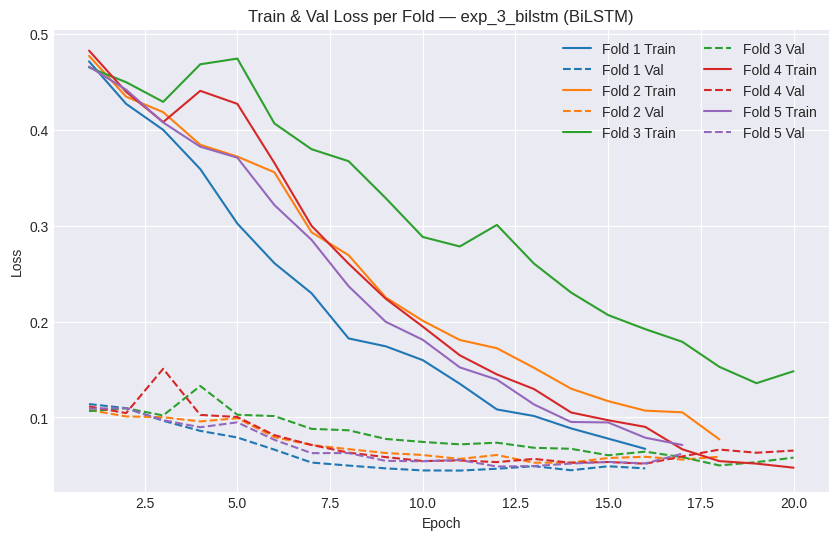


Finalizing experiment...
  Predictions saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_bilstm/exp_3_bilstm_prediction.csv

✓ Experiment 'exp_3_bilstm' finalized!
  Location: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_bilstm
  Folds completed: 5
  Best fold: 1 (ROC AUC: 0.9730)
  Average ROC AUC: 0.9638 ± 0.0051
Experiment saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_bilstm


(BiLSTM(
   (embedding): Embedding(101, 64, padding_idx=0)
   (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (fc): Linear(in_features=256, out_features=1, bias=True)
 ),
 {'loss': 0.062226012305124416,
  'accuracy': 0.9108315098468271,
  'precision': 0.9112814895947426,
  'recall': 0.9102844638949672,
  'f1': 0.9107827038861521,
  'roc_auc': np.float64(0.9638650412498981),
  'TP': np.int64(832),
  'FP': np.int64(81),
  'TN': np.int64(833),
  'FN': np.int64(82)},
 {'loss': 0.29516856120744506,
  'accuracy': 0.9076990376202975,
  'precision': 0.9066317626527051,
  'recall': 0.9090113735783028,
  'f1': 0.90782000873744,
  'roc_auc': np.float64(0.9670549711469794),
  'TP': np.int64(1039),
  'FP': np.int64(107),
  'TN': np.int64(1036),
  'FN': np.int64(104)})

In [26]:
# Run BiLSTM Experiment
SAVE_LSTM = True # Set to False to skip saving

lstm_params = {
    'vocab_size': tokenizer.vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': DROPOUT
}

run_experiment(BiLSTM, "BiLSTM", lstm_params, "exp_3_bilstm", save_model=SAVE_LSTM)

### 4. Hybrid Model (Numeric + Text)

From the above results, we see that CharCNN outperforms BiLSTM, therefore, we will choose that for the hybrid model, along with a parallel MLP to capture the numeric features that we engineered.

In [27]:
# Define Hybrid Model Architecture
class HybridModel(nn.Module):
    def __init__(self, vocab_size, numeric_input_dim, embedding_dim=64, num_filters=128, filter_sizes=[3, 4, 5], dropout=0.3):
        super(HybridModel, self).__init__()

        # Text Branch (CNN)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.text_out_dim = len(filter_sizes) * num_filters

        # Numeric Branch (MLP)
        self.numeric_fc = nn.Sequential(
            nn.Linear(numeric_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.numeric_out_dim = 64

        # Combined
        self.fc_final = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.text_out_dim + self.numeric_out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_numeric, x_text, x_img=None):
        # Text Path
        embedded = self.embedding(x_text).permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        text_features = torch.cat(pooled, dim=1)

        # Numeric Path
        numeric_features = self.numeric_fc(x_numeric)

        # Combine
        combined = torch.cat((text_features, numeric_features), dim=1)
        return torch.sigmoid(self.fc_final(combined))


=== Running Experiment: exp_3_hybrid (HybridModel) ===
Saving Model: True
Experiment 'exp_3_hybrid' initialized at: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_hybrid
Mode: Incremental saving (5 folds)

--- Fold 1/5 ---
Epoch 1/20 - Train Loss: 0.2953 - Val Loss: 0.0417 - Val AUC: 0.9754
Epoch 5/20 - Train Loss: 0.1089 - Val Loss: 0.0282 - Val AUC: 0.9880
Epoch 10/20 - Train Loss: 0.0579 - Val Loss: 0.0299 - Val AUC: 0.9884
Early stopping triggered at epoch 10 (no improvement in val loss for 5 epochs)
Fold 1 Best Val AUC: 0.9884
  Fold 1/5 saved | ROC AUC: 0.9884

--- Fold 2/5 ---
Epoch 1/20 - Train Loss: 0.3057 - Val Loss: 0.0518 - Val AUC: 0.9662
Epoch 5/20 - Train Loss: 0.1100 - Val Loss: 0.0355 - Val AUC: 0.9809
Epoch 10/20 - Train Loss: 0.0539 - Val Loss: 0.0441 - Val AUC: 0.9832
Early stopping triggered at epoch 10 (no improvement in val loss for 5 epochs)
Fold 2 Best Val AUC: 0.9832
  Fold 2/5 saved | ROC AUC: 0.9832

--- Fold 3/5 ---
Epoch 1/20 - Train Loss: 0.3138

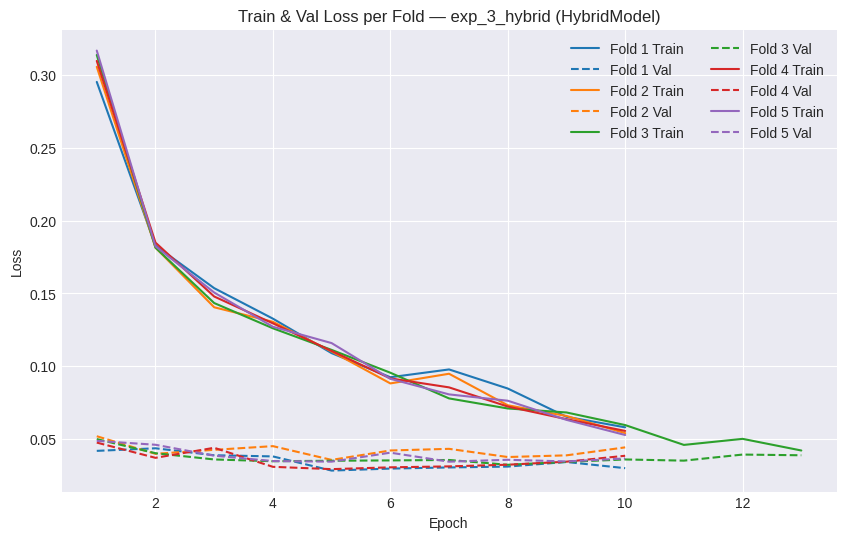


Finalizing experiment...
  Predictions saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_hybrid/exp_3_hybrid_prediction.csv

✓ Experiment 'exp_3_hybrid' finalized!
  Location: /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_hybrid
  Folds completed: 5
  Best fold: 1 (ROC AUC: 0.9884)
  Average ROC AUC: 0.9853 ± 0.0018
Experiment saved to /content/drive/MyDrive/fraud-grp-proj/experiments/exp_3_hybrid


(HybridModel(
   (embedding): Embedding(101, 64, padding_idx=0)
   (convs): ModuleList(
     (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
     (1): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
     (2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
   )
   (numeric_fc): Sequential(
     (0): Linear(in_features=49, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, out_features=64, bias=True)
     (4): ReLU()
   )
   (fc_final): Sequential(
     (0): Dropout(p=0.3, inplace=False)
     (1): Linear(in_features=448, out_features=64, bias=True)
     (2): ReLU()
     (3): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 {'loss': 0.03652230929939827,
  'accuracy': 0.9409190371991247,
  'precision': 0.9448123620309051,
  'recall': 0.936542669584245,
  'f1': 0.9406593406593406,
  'roc_auc': np.float64(0.9838100733065517),
  'TP': np.int64(856),
  'FP': np.int64(50),
  'TN': np.int64(864),
  'FN': np.int64(

In [28]:
# Run Hybrid Model Experiment
SAVE_HYBRID = True # Set to False to skip saving

hybrid_params = {
    'vocab_size': tokenizer.vocab_size,
    'numeric_input_dim': X_numeric_train_scaled.shape[1],
    'embedding_dim': EMBEDDING_DIM,
    'num_filters': 128,
    'filter_sizes': [3, 4, 5],
    'dropout': DROPOUT
}

run_experiment(HybridModel, "HybridModel", hybrid_params, "exp_3_hybrid", save_model=SAVE_HYBRID)

The hybrid model has the best fold performance so far, which tells us that adding in the numeric features does help improve performance.

Although the hybrid model is the best performing neural network so far, we are unlikely able to Optuna tune it due to the complexity of the model and training time required. For the neural network models, only MLP would be feasible for Optuna tuning, but since it performed worst, we will not pursue that further.